<font size="5.8"> Summary </font> 

In [1]:
from IPython.display import HTML

HTML("""
<video width="600" controls>
  <source src="streamlit_churn_modelling.webm" type="video/webm">
  Your browser does not support the video tag.
</video>
""")

Streamlit is an open-source Python library designed to simplify the development of web applications for machine learning and data science. Ideal for data scientists and ML engineers, it facilitates creating a user-friendly application for training and deploying a customer churn prediction model. The app allows users to input data, view churn risk predictions, and interact with features for model training, evaluation, and gaining insights into customer retention strategies.

A Streamlit app has been created to train and deploy a customer churn prediction model. It enables users to input data, view churn risk predictions, and interact with features for model training, evaluation, and gaining insights into customer retention strategies. The app is hosted on Streamlit's community cloud. Here is the deployed app, offering a comprehensive walkthrough for training a machine learning model to predict customer churn: https://customer-churnprediction-train59.streamlit.app

The app will go to sleep if it remains inactive for an extended period, which may result in the following error message:

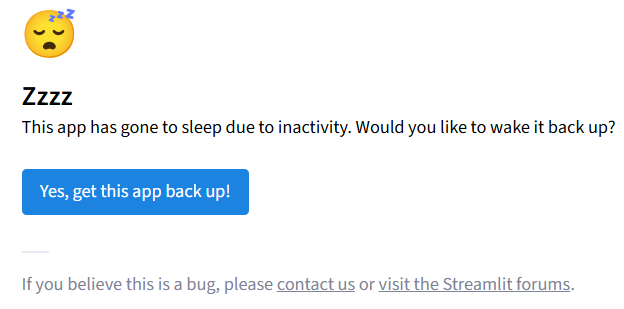

You can simply get the app running by clicking on **Yes, get this app back up!"**

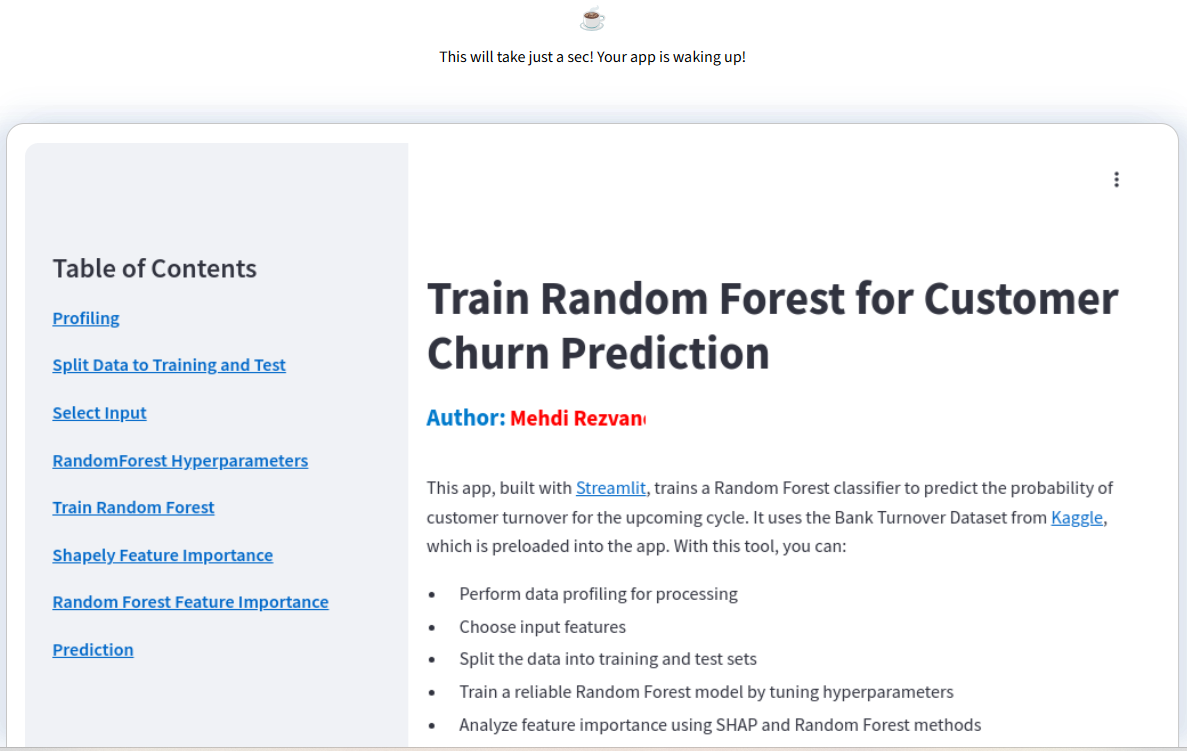

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Streamlit-Code" data-toc-modified-id="Streamlit-Code-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Streamlit Code</a></span></li></ul></div>

Here is the streamlit code to create the app:

# Streamlit Code

In [ ]:
import streamlit as st
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from streamlit_pandas_profiling import st_profile_report
#from pydantic_settings import BaseSettings
from pandas_profiling import ProfileReport
import shap
from matplotlib.ticker import PercentFormatter


st.title('Train Random Forest for Customer Churn Prediction')

# Typing effect that stops at the author's name length and repeats from the beginning
st.markdown(
    """
    <style>
        .author-title {
            font-size: 1.3em;
            font-weight: bold;
            color: #007acc; /* Color for "Author:" */
            white-space: nowrap;
            vertical-align: middle; /* Ensures alignment with animated text */
        }
    
        .author-name {
            font-size: 1.2em;
            font-weight: bold;
            color: red; /* Color for the author's name */
            overflow: hidden;
            white-space: nowrap;
            border-right: 3px solid;
            display: inline-block;
            vertical-align: middle; /* Aligns with the static "Author:" text */
            animation: typing 5s steps(20, end) infinite, blink-caret 0.75s step-end infinite;
            max-width: 10ch; /* Limit width to fit text length */
        }
    
        /* Typing effect */
        @keyframes typing {
            0% { max-width: 0; }
            50% { max-width: 30ch; } /* Adjust to match the name's length */
            100% { max-width: 0; } /* Reset back to zero */
        }
    
        /* Blinking cursor animation for the author's name */
        @keyframes blink-caret {
            from, to { border-color: transparent; }
            50% { border-color: red; }
        }
    </style>
    
    <p><span class="author-title">Author:</span> <span class="author-name">Mehdi Rezvandehy</span></p>

    """,
    unsafe_allow_html=True
)

st.write("""""")

st.write(
    """This app is created by [streamlit](https://streamlit.io/) to train a model to predict 
    customer turnover for next cycle. Random forest classifier is trained by Bank Turnover Dataset from 
    [Kaggle](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling/version/1).
     The app is trained by 10 inputs (predictors). The user inputs are `Geography`, `CreditScore`, 
     `Gender`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `HasCrCard`, `IsActiveMember`, `EstimatedSalary`"""
)
st.image('DataTable.jpg')

#with st.form('input'):
#    churn_file = st.file_uploader('Upload your churn data')
#    st.form_submit_button()


#if churn_file is None:
#    rf_pickle = open("random_forest_churn.pickle", "rb")
#    rfc = pickle.load(rf_pickle)
#    std_pickle = open("std.pickle", "rb")
#    scaler = pickle.load(std_pickle)
#    rf_pickle.close()
#    std_pickle.close()
#
#else:
churn_file = 'Churn_Modelling.csv'
if churn_file is not None:
    df = pd.read_csv(churn_file)
    # Shuffle the data
    np.random.seed(42) 
    df
    if st.button("profiling", type="primary"):
        profile = ProfileReport(df, title='Pandas Profiling Report')
        st_profile_report(profile)
    
    df = df.reindex(np.random.permutation(df.index))
    df.reset_index(inplace=True, drop=True) # Reset index
    
    # Remove 'RowNumber','CustomerId','Surname' features
    df = df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=False)
    
    
    # Training and Test
    st.subheader("Split Data to Training and Test")
    test_size = st.number_input("proportion of test data", min_value=0.1, max_value=0.4)
    
    spt = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_idx, test_idx in spt.split(df, df['Exited']):
        train_set_strat = df.loc[train_idx]
        test_set_strat  = df.loc[test_idx] 
        
    train_set_strat.reset_index(inplace=True, drop=True) # Reset index
    test_set_strat.reset_index(inplace=True, drop=True) # Reset index  
    
    st.subheader("Select Input")
    features = ["Geography", "CreditScore", "Gender", "Age", "Tenure",
     "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]
    selected_features = st.multiselect('Select features:', features)
    selected_features_test = selected_features.copy()
 
    st.subheader("RandomForest Hyperparameters")
    n_estimators = st.number_input("n_estimators", min_value=10, max_value=200)
    max_depth = st.number_input("max_depth", min_value=5, max_value=30)
    min_samples_split = st.number_input("min_samples_split", min_value=5, max_value=30)
    bootstrap = st.selectbox("bootstrap", options=[True, False])
    random_state = st.number_input("random_state", min_value=1)
 
    # Random Forest for taining set
    if st.button("Train Random Forest", type="primary"):
        # Text Handeling
        # Convert Geography to one-hot-encoding
        clmn = []
        # Convert gender to 0 and 1
        if 'Gender' in selected_features:
            ordinal_encoder = OrdinalEncoder()
            clmn.append('Gender')
            train_set_strat['Gender'] = ordinal_encoder.fit_transform(train_set_strat[['Gender']])
        
        # Remove 'Geography'
        if 'Geography' in selected_features:
            Geog_1hot = pd.get_dummies(train_set_strat['Geography'],prefix='Is')
            clmn.append(list(Geog_1hot.columns))        
            selected_features.remove('Geography')        
            train_set_strat = train_set_strat.drop(['Geography'],axis=1,inplace=False)
            train_set_strat = pd.concat([Geog_1hot,train_set_strat], axis=1) # Concatenate rows
            
        if 'NumOfProducts' in selected_features:
            clmn.append('NumOfProducts')       
            
        if 'HasCrCard' in selected_features:
            clmn.append('HasCrCard') 
        
        if 'IsActiveMember' in selected_features:
            clmn.append('IsActiveMember') 
        
        # Standardization 
        # Make training features and target
        X_train = train_set_strat.drop("Exited", axis=1)
        y_train = train_set_strat["Exited"].values
     
        selected_features_con = [i for i in selected_features if i not in clmn]
        if len(selected_features_con)==0 and len(clmn)==0:
            raise ValueError("Please select at least one input!")
     
        # Divide into two training sets (with and without standization)
        X_train_for_std = X_train[selected_features_con]
  
        clmn = [item for sublist in clmn for item in (sublist if isinstance(sublist, list) else [sublist])]
  
        X_train_not_std = X_train[clmn]
        st.session_state.clmns_all = selected_features_con + clmn
     
        #
        scaler = StandardScaler()
        scaler.fit(X_train_for_std)
        #
        df_train_std = scaler.transform(X_train_for_std)
        X_train_std = np.concatenate((df_train_std, X_train_not_std), axis=1)

        # Initialize the progress bar
        progress_bar = st.progress(0)
        progress_step = 100 / 3  # Assuming 3 main steps in your process        
  
        rnd = RandomForestClassifier(n_estimators=n_estimators, max_depth= max_depth, 
                                     min_samples_split= 20, bootstrap= bootstrap, 
                                     random_state=random_state)
        rnd.fit(X_train_std, y_train)
        st.session_state.X_train_std = X_train_std
        st.session_state.y_train = y_train

        progress_bar.progress(100)  # Complete the progress bar
        
        # Convert gender to 0 and           
        if 'Gender' in selected_features_test:
            ordinal_encoder = OrdinalEncoder()
            test_set_strat['Gender'] = ordinal_encoder.fit_transform(test_set_strat[['Gender']])
        
        # Remove 'Geography'
        if 'Geography' in selected_features_test:
            Geog_1hot = pd.get_dummies(test_set_strat['Geography'],prefix='Is')        
            test_set_strat = test_set_strat.drop(['Geography'],axis=1,inplace=False)
            test_set_strat = pd.concat([Geog_1hot,test_set_strat], axis=1) # Concatenate rows
        
        # Standardize data
        X_test = test_set_strat.drop("Exited", axis=1)
        y_test = test_set_strat["Exited"].values
        #
        X_test_for_std = X_test[selected_features_con]
        X_test_not_std = X_test[clmn]
        #
        df_test_std = scaler.transform(X_test_for_std)
        X_test_std = np.concatenate((df_test_std,X_test_not_std), axis=1)
        
        # Random Forest for test set
        y_test_pred = rnd.predict(X_test_std)
        y_test_proba_rnd = rnd.predict_proba(X_test_std)
        
        score = accuracy_score(y_test_pred, y_test)
  
        st.markdown(f"""<p style='font-size:24px;'>Random Forest 
          model was trained. The accuracy score for test set is <strong>{int(score*100)}%</strong></p>""", unsafe_allow_html=True)
    
        st.session_state.rnd = rnd    
    # Apply feature importance with shapely
    if st.button("Shapely Feature Importance", type="secondary"):
        # Plot the importance of features
        font = {'size'   : 7}
        plt.rc('font', **font)
    
        fig, ax1 = plt.subplots(figsize=(6, 3), dpi= 180, facecolor='w', edgecolor='k')   
        # Initialize the progress bar
        #progress_bar = st.progress(0)
        progress_step = 100 / 2     
        explainer = shap.TreeExplainer(st.session_state.rnd)
        X_train_std = pd.DataFrame(st.session_state.X_train_std, 
            columns=st.session_state.clmns_all)

        shap_values = explainer(X_train_std)
        shap_values_for_class = shap_values[..., 0]
        progress_bar = st.progress(int(progress_step))

        shap.plots.beeswarm(shap_values_for_class, 
            max_display=len(st.session_state.clmns_all))
        st.pyplot(fig)
        # Complete the progress bar
        progress_bar.progress(100)


    # Apply feature importance with Random Forest
    if st.button("Random Forest Feature Importance", type="secondary"):
        class prfrmnce_plot(object):
            """Plot performance of features to predict a target"""
            def __init__(self,importance: list, title: str, ylabel: str,clmns: str,
                        titlefontsize: int=10, xfontsize: int=5, yfontsize: int=8) -> None:
                self.importance    = importance
                self.title         = title 
                self.ylabel        = ylabel  
                self.clmns         = clmns  
                self.titlefontsize = titlefontsize 
                self.xfontsize     = xfontsize 
                self.yfontsize     = yfontsize
                
            #########################    
            
            def bargraph(self, select: bool= False, fontsizelable: bool= False, xshift: float=-0.1, nsim: int=False
                         ,yshift: float=0.01,perent: bool=False, xlim: list=False,axt=None,
                         ylim: list=False, y_rot: int=0, graph_float: bool=True) -> pd.DataFrame():
                ax1 = axt or plt.axes()
                if not nsim:
                    # Make all negative coefficients to positive
                    sort_score=sorted(zip(abs(self.importance),self.clmns), reverse=True)
                    Clmns_sort=[sort_score[i][1] for i in range(len(self.clmns))]
                    sort_score=[sort_score[i][0] for i in range(len(self.clmns))]
                else:
                    importance_agg=[]
                    importance_std=[]
                    for iclmn in range(len(self.clmns)):
                        tmp=[]
                        for isim in range(nsim):
                            tmp.append(abs(self.importance[isim][iclmn]))
                        importance_agg.append(np.mean(tmp))
                        importance_std.append(np.std(tmp))
                        
                    # Make all negative coefficients to positive
                    sort_score=sorted(zip(importance_agg,self.clmns), reverse=True)
                    Clmns_sort=[sort_score[i][1] for i in range(len(self.clmns))]
                    sort_score=[sort_score[i][0] for i in range(len(self.clmns))]                
                    
        
                index1 = np.arange(len(self.clmns))
                # select the most important features
                if (select):
                    Clmns_sort=Clmns_sort[:select]
                    sort_score=sort_score[:select]
                ax1.bar(Clmns_sort, sort_score, width=0.6, align='center', alpha=1, edgecolor='k', capsize=4,color='b')
                plt.title(self.title,fontsize=self.titlefontsize)
                ax1.set_ylabel(self.ylabel,fontsize=self.yfontsize)
                ax1.set_xticks(np.arange(len(Clmns_sort)))
                
                ax1.set_xticklabels(Clmns_sort,fontsize=self.xfontsize, rotation=90,y=0.02)   
                if (perent): plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
                ax1.xaxis.grid(color='k', linestyle='--', linewidth=0.2) 
                if (xlim): plt.xlim(xlim)
                if (ylim): plt.ylim(ylim)
                if (fontsizelable):
                    for ii in range(len(sort_score)):
                        if (perent):
                            plt.text(xshift+ii, sort_score[ii]+yshift,f'{"{0:.1f}".format(sort_score[ii]*100)}%',
                            fontsize=fontsizelable,rotation=y_rot,color='k')     
                        else:
                            if graph_float:
                                plt.text(xshift+ii, sort_score[ii]+yshift,f'{"{0:.3f}".format(sort_score[ii])}',
                                fontsize=fontsizelable,rotation=y_rot,color='k') 
                            else:
                                plt.text(xshift+ii, sort_score[ii]+yshift,f'{"{0:.0f}".format(sort_score[ii])}',
                                    fontsize=fontsizelable,rotation=y_rot,color='k')                             
                            
                
                dic_Clmns={}
                for i in range(len(Clmns_sort)):
                    dic_Clmns[Clmns_sort[i]]=sort_score[i]
                    
        
         # Plot the importance of features
        font = {'size'   : 7}
        plt.rc('font', **font)
        fig, ax1 = plt.subplots(figsize=(6, 3), dpi= 180, facecolor='w', edgecolor='k')
        
        
        # Calculate importance
        importance = abs(st.session_state.rnd.feature_importances_)
        
        df_most_important = prfrmnce_plot(importance, title=f'Feature Importance by Random Forest', 
                    ylabel='Random Forest Score',clmns=st.session_state.clmns_all,titlefontsize=9, 
                    xfontsize=7, yfontsize=8).bargraph(perent=True,fontsizelable=8,xshift=-0.25,axt=ax1,
                    yshift=0.01,ylim=[0, max(importance)+0.05], xlim=[-0.5,len(st.session_state.clmns_all)+0.5], y_rot=0)      
                    
        st.pyplot(fig)

